In [ ]:
from google.colab import drive

drive.mount('/content/drive')

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cv2
import numpy as np
import matplotlib.pyplot as plt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Image presentation

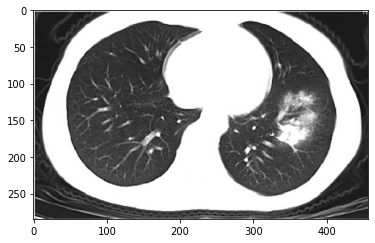

In [ ]:
img = cv2.imread('/content/drive/My Drive/EISTI2A/IntroAIIP/Images/COVID.jpg')

#Image originale
plt.imshow(img)
plt.show()

## Segmentation par seuillage de l’histogramme

### Import Library

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from skimage.color import rgb2gray, rgb2hsv
from skimage.morphology import area_opening
from skimage.exposure import histogram
from skimage.filters import threshold_otsu

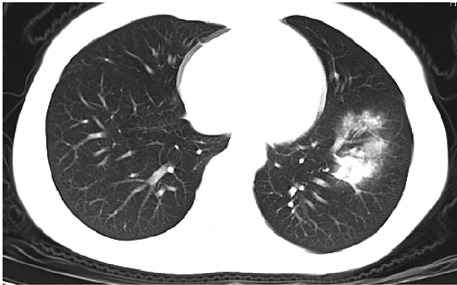

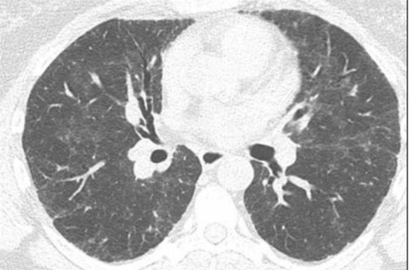

In [ ]:
#Display Images
from IPython.display import Image
from IPython.display import display
covid = Image(r"/content/drive/My Drive/EISTI2A/IntroAIIP/Images/COVID.jpg")
non_covid = Image(r"/content/drive/My Drive/EISTI2A/IntroAIIP/Images/NONCOVID.jpg")
images = [covid,non_covid]
display(covid,non_covid)


### Pictures Histogram

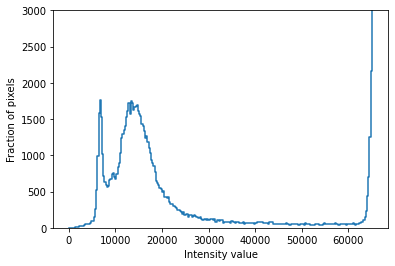

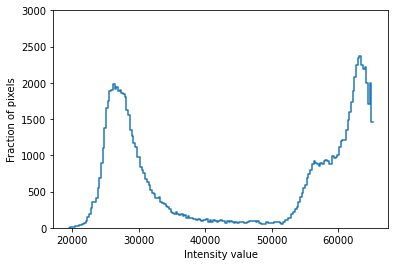

In [ ]:
covid = imread(r"/content/drive/My Drive/EISTI2A/IntroAIIP/Images/COVID.jpg")
non_covid = imread(r"/content/drive/My Drive/EISTI2A/IntroAIIP/Images/NONCOVID.jpg")
covid_gray = rgb2gray(covid)
freq, bins = histogram(covid_gray)
plt.step(bins*256, freq)
plt.ylim([0, 3000])
plt.xlabel('Intensity value')
plt.ylabel('Fraction of pixels')
plt.show()
covid_gray = rgb2gray(non_covid)
freq, bins = histogram(covid_gray)
plt.step(bins*256, freq)
plt.ylim([0, 3000])
plt.xlabel('Intensity value')
plt.ylabel('Fraction of pixels')
plt.show()


### Tresholding Pictures in 2 classes from the histogram

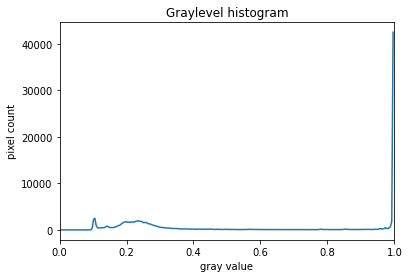

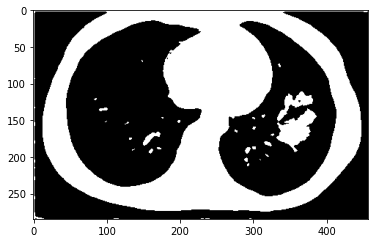

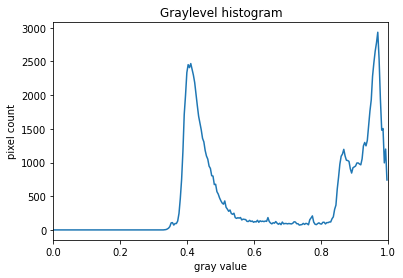

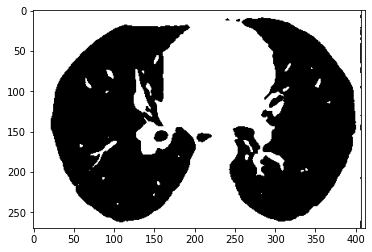

In [ ]:
from skimage.filters import threshold_otsu
import numpy as np
import glob
import matplotlib.pyplot as plt
import skimage.io
import skimage.color
import skimage.filters

images =[imread(r"/content/drive/My Drive/EISTI2A/IntroAIIP/Images/COVID.jpg"),imread(r"/content/drive/My Drive/EISTI2A/IntroAIIP/Images/NONCOVID.jpg")]
for image in images:
    # On convertit l'image en grayscale
    gray_image = skimage.color.rgb2gray(image)

    # on enlève le bruit de l'image
    blurred_image = skimage.filters.gaussian(gray_image, sigma=1.0)

    # Histogramme de l'image sans bruit
    histogram, bin_edges = np.histogram(blurred_image, bins=256, range=(0.0, 1.0))
    plt.plot(bin_edges[0:-1], histogram)
    plt.title("Graylevel histogram")
    plt.xlabel("gray value")
    plt.ylabel("pixel count")
    plt.xlim(0, 1.0)
    plt.show()

    #On cherche le treshold optimal
    image = blurred_image
    thresh = threshold_otsu(image)
    binary = image > thresh

    fig, ax = plt.subplots()
    plt.imshow(binary, cmap='gray')
    plt.show()

## K-means Segmentation

[[255. 255. 255.]
 [253. 253. 253.]
 [255. 255. 255.]
 ...
 [ 98.  98.  98.]
 [ 95.  95.  95.]
 [ 87.  87.  87.]]
(130245, 3)


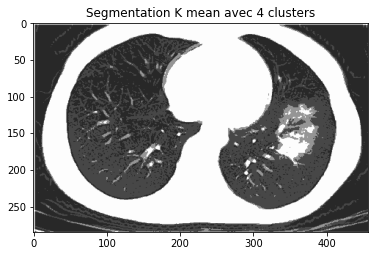

In [ ]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#conversion de l'image en une matrice de pixels avec 3 couleurs RGB, donc matrice MxNx3. Chaque ligne est un vecteur dans l'espace 3D des RGB
pixel_values = img.reshape((-1, 3))
# conversion en décimal (nécessaire pour la méthode d'OpenCV)
pixel_values = np.float32(pixel_values)
print(pixel_values)
print(pixel_values.shape)

# définition du critère d'arrêt.
#EPS arrête l'algo si epsilon est atteint (la précision)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)

# nombre de clusters (K) on peut aussi mettre 2 pour n'avoir que 2 couleurs
k = 4
_, labels, (centers) = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

# reconversion en valeurs 8 bit
centers = np.uint8(centers)

# flatten la matrice de labels
labels = labels.flatten()

# conversion de tous les pixels en la couleur des centroids
segmented_image = centers[labels.flatten()]
seg=segmented_image
# redimension dans la taille d'origine
segmented_image = segmented_image.reshape(img.shape)
# affichage
plt.imshow(segmented_image)
plt.title('Segmentation K mean avec '+str(k)+' clusters')
plt.show()


# Histogramme des nuances de gris

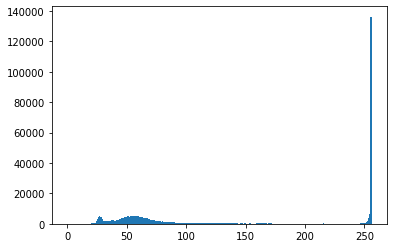

In [ ]:
#Histogramme sur 256 valeurs
plt.hist(img.ravel(),256,[0,256])
plt.show()

# Labellisation

In [ ]:
img = cv2.imread('/content/drive/My Drive/EISTI2A/IntroAIIP/Images/COVID.jpg')

img = cv2.bitwise_not(img)

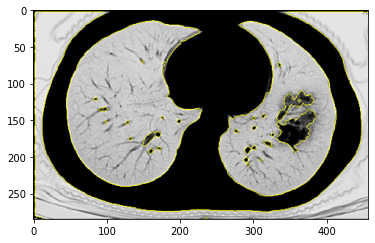

In [ ]:


from skimage.color import rgb2hed
from skimage.filters import threshold_otsu
from skimage.morphology import opening, closing, disk
from skimage.segmentation import mark_boundaries

hed = rgb2hed(img) #hed colorspace
t=threshold_otsu(hed[:,:,0])
mask=hed[:,:,0]>t
mask=closing(opening(mask,disk(1)),disk(2)) #opening remove small objects, closing removes the holes in the objects

plt.figure()
plt.imshow(mark_boundaries(img,mask))
plt.show()

25


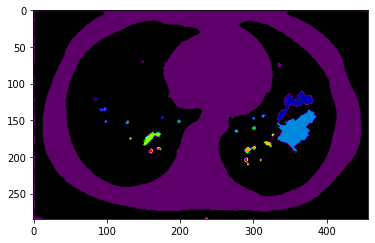

In [ ]:
from skimage.measure import label

lab = label(mask, connectivity=2)
print(lab.max())

plt.figure()
plt.imshow(lab, cmap='nipy_spectral')
plt.show()

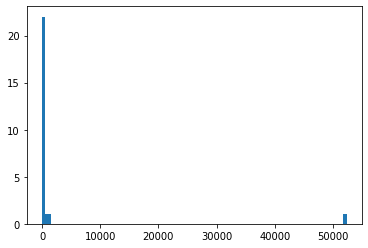

In [ ]:
obj_sizes=[]
for i in range(1,lab.max()+1):
  obj_sizes += [(lab==i).sum()]
obj_sizes = np.array(obj_sizes)

plt.figure()
plt.hist(obj_sizes, bins=100)
plt.show()

# Localisation des zones à suivre

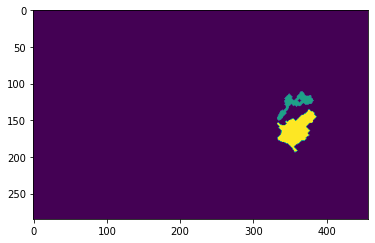

[[334, 150, 383, 112], [334, 193, 387, 136]]


In [ ]:
interesting_lab = []
coord_rectangle = [] 
lab_small = np.zeros_like(lab)
for i in range(1,lab.max()):
  if((lab==i).sum()<50000):
    if((lab==i).sum()>500):
      lab_small[lab==i]=i
      interesting_lab.append(i)
      #Get x of the starting point label
      x1=1000
      for y in lab==i:
        rank=1
        for x in y:
          if (rank<x1 and x!=0):
            x1=rank
          rank=rank+1
      #Get y of the starting point label
      y1=285
      for y in reversed(lab==i):
        y1=y1-1
        if y.sum()!=0:
          break
      #Get x of the ending point label
      x2=0
      for y in reversed(lab==i):
        rank=457
        for x in reversed(y):
          if (rank>x2 and x!=0):
            x2=rank
          rank=rank-1
      #Get y of the ending point label
      y2=0
      for y in lab==i:
        y2=y2+1
        if y.sum()!=0:
          break
      coord_rectangle.append([x1,y1,x2,y2])

plt.figure()
plt.imshow(lab_small)
plt.show()
print(coord_rectangle)

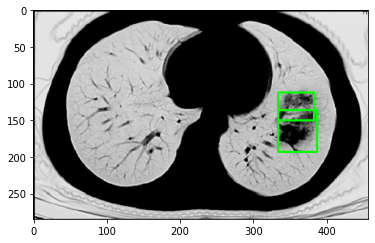

In [ ]:

  
#Draw a rectangle
import random
image_label = img
for i in range(len(coord_rectangle)):
  #color=random.randint(100,255)
  image_label=cv2.rectangle(image_label, (coord_rectangle[i][0],coord_rectangle[i][1]) ,(coord_rectangle[i][2],coord_rectangle[i][3]), (0,255,0), 2)
plt.figure()
plt.imshow(image_label)
plt.show()